## [Forecasting non-stationary time series](https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH07/CH07.ipynb)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [33]:
df = pd.read_csv('../data/SBER_250914_250915.csv', sep=';')

df["date_str"]=df["<DATE>"].apply(lambda x: str(x).zfill(6)).astype(str)
df["time_str"]=df["<TIME>"].apply(lambda x: str(x).zfill(6)).astype(str)
df["datetime_str"]=df["date_str"]+df["time_str"]
df["time_utc"]= pd.to_datetime(df["datetime_str"], format='%y%m%d%H%M%S', utc=True)
#df = df.set_index("time_utc")
df.drop(["date_str", "time_str", "datetime_str", "<DATE>", "<TIME>"], axis=1, inplace=True)
df.rename(columns={"<OPEN>": "open", "<HIGH>": "high", "<LOW>": "low", "<CLOSE>": "close", "<VOL>": "volume"}, inplace=True)

df = df.tail(200)
df = pd.DataFrame({'close': df['close']})

df

,close
829,302.25
830,302.26
831,302.28
832,302.23
833,302.47
...,...
1024,302.36
1025,302.37
1026,302.34
1027,302.44


In [34]:
train = df[:int(0.9*len(df))]
test = df[int(0.9*len(df)):]

print(len(train), len(test))

180 20


In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in order_list:
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [36]:
from itertools import product

ps = range(0, 3, 1)
qs = range(0, 3, 1)

order_list = list(product(ps, qs))
order_list

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [37]:
result_df = optimize_ARIMA(train['close'], order_list, 1)
result_df

C:\envs\vertr\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 0)",-384.637592
1,"(2, 0)",-384.527414
2,"(1, 1)",-384.442226
3,"(0, 2)",-384.334458
4,"(2, 1)",-382.781484
5,"(0, 1)",-382.759321
6,"(1, 2)",-382.460390
7,"(2, 2)",-381.260413
8,"(0, 0)",-377.335186


In [38]:
model = SARIMAX(train['close'], order=(1,1,1))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  180
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 195.221
Date:                Sun, 26 Oct 2025   AIC                           -384.442
Time:                        20:03:20   BIC                           -374.880
Sample:                             0   HQIC                          -380.565
                                - 180                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5949      0.250      2.377      0.017       0.104       1.085
ma.L1         -0.3925      0.284     -1.383      0.167      -0.949       0.164
sigma2         0.0066      0.001     12.924      0.0

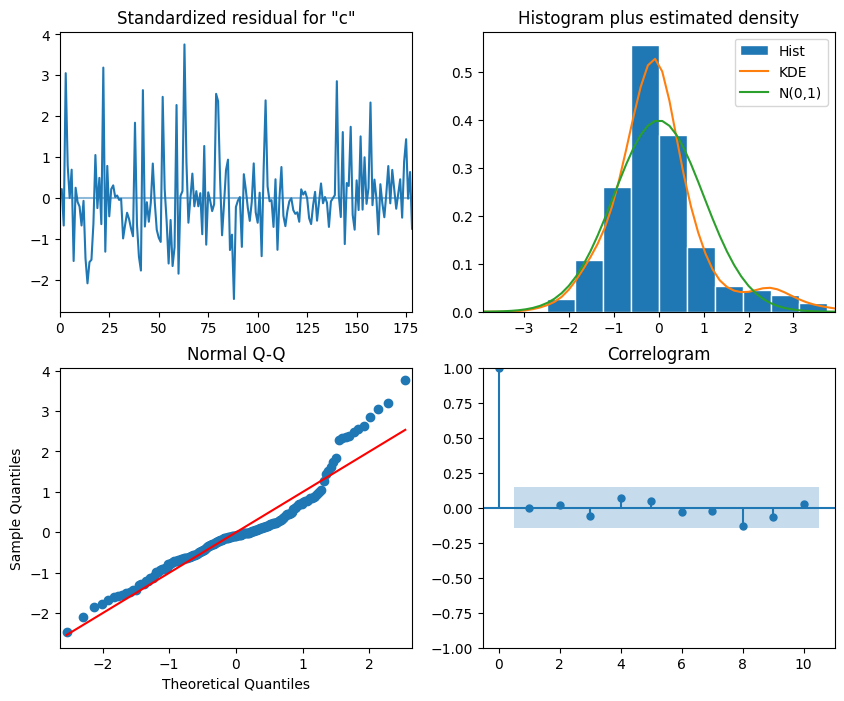

In [39]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,1.205853e-09,0.999972
2,1.503728e-09,1.000000
3,1.399878e-05,1.000000
4,1.066273e-04,1.000000
5,1.075283e-04,1.000000
6,1.134550e-04,1.000000
7,1.135350e-04,1.000000
8,1.955885e-04,1.000000
9,2.035844e-04,1.000000
10,2.242422e-04,1.000000


p. in[53]